<a href="https://colab.research.google.com/github/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/01_01_data_import.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%load_ext autoreload
%autoreload 2

Create a kaggle account if you don't already have one, then download your kaggle API key.
Info on how to get your api key (kaggle.json) here:
https://github.com/Kaggle/kaggle-api#api-credentials
Place the kaggle.json file in the correct directory (~/.kaggle).

Let's try to unify the Google Colab environment and the local environment.

If you are running on google colab, then in the next cell you'll be presented
with a widget. Use it to browse to the kaggle.json file.
(Note: You might have to show hidden files/folders in the file browser) 

It will also clone the workshop repository and change into its directory.

In [2]:
from pathlib import Path
try:
    import os
    # See if we are running on google.colab
    import google.colab
    from google.colab import files
    # Configure kaggle
    files.upload()  # Find the kaggle.json file in your ~/.kaggle directory.
    !pip install -q kaggle
    !mkdir -p ~/.kaggle
    !mv kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    # Download the workshop repo and change to its directory
    # For now edit the username/password. This will be removed when the repo is made public.
    !git clone https://<username>:<password>@github.com/SachsLab/IntracranialNeurophysDL.git ../repo
    os.chdir('../repo')
    IN_COLAB = True
except:
    import os
    import sys
    if Path.cwd().stem == 'notebooks':
        os.chdir(Path.cwd().parent)
    os.environ['PATH'] = os.environ['PATH'] + ';' + str(Path(sys.executable).parent / 'Scripts')
    IN_COLAB = False

Saving kaggle.json to kaggle.json
  Cloning https://github.com/ahwillia/tensortools to /tmp/pip-req-build-539w0qxn
  Running command git clone -q https://github.com/ahwillia/tensortools /tmp/pip-req-build-539w0qxn
  Stored in directory: /tmp/pip-ephem-wheel-cache-7yztbp0p/wheels/e4/4f/c6/b7ea145adb6874a9583dfe0c5c8ef3048335f4f885c6ee01ac
Successfully built tensortools


Now that your system is configured to use kaggle, whether local or running on colab,
we check for the existence of the datadir, and if it's not there we download the data
as a zip file (2.2 GB), then unzip it, then delete the zip file.

While running on google colab, this takes about a minute to download and another minute to unzip.

While running locally, this can take a long time depending on your internet connection. The
PyCharm notebook interface doesn't give feedback about download or unzip status, so you may
want to download and extract from an Anaconda prompt, in the repository parent directory:
```
kaggle datasets download -d cboulay/kjm-ecog-faces-basic
# Mac/Linux only:
unzip faces-basic.zip -d data/kjm_ecog/converted/
# Windows users will have to use the Explorer interface and extract to data\kjm_ecog
```

This dataset may still be private, in which case you will have to ask Chad to grant you
access.


In [3]:
datadir = Path.cwd() / 'data' / 'kjm_ecog'
if not (datadir / 'converted').is_dir():
    !kaggle datasets download -d cboulay/kjm-ecog-faces-basic
    print("Finished downloading. Now extracting contents...")
    data_path = Path('kjm-ecog-faces-basic.zip')
    import zipfile
    with zipfile.ZipFile(data_path, 'r') as zip_ref:
        zip_ref.extractall(datadir / 'converted' / 'faces_basic')
    data_path.unlink()

100% 2.24G/2.24G [00:38<00:00, 26.1MB/s]
100% 2.24G/2.24G [00:38<00:00, 62.4MB/s]
Finished downloading. Now extracting contents...


We can now start working with the data.
We will import a single file that contains processed band-power data.


In [0]:
SUB_ID = 'de'
from data.utils.fileio import from_neuropype_h5
test_file = datadir / 'converted' / 'faces_basic' / (SUB_ID + '_bp.h5')
chunks = from_neuropype_h5(test_file)

Let's quickly inspect the data to see what we have.


In [28]:
import pandas as pd

# Get the 'signals' chunk
chunk_names = [_[0] for _ in chunks]
chunk = chunks[chunk_names.index('signals')][1]
ax_types = [_['type'] for _ in chunk['axes']]

print("The 'signals' chunk has data with shape {}.".format(chunk['data'].shape))
print("The axes types are {}".format(ax_types))

instance_axis = chunk['axes'][ax_types.index('instance')]
print("The trial label frequencies are \n{}".format(pd.value_counts(instance_axis['data']['Marker'])))

The 'signals' chunk has data with shape (603, 17, 31).
The axes types are ['instance', 'time', 'space']
The trial label frequencies are 
ISI      303
face     150
house    150
Name: Marker, dtype: int64


The data contain 603 trials, with each trial having
17 samples in time, and 31 channels.
Of the 603 trials, 303 or inter-stimulus intervals, and the remaining
300 are split between `face` and `house`.

When a data container has more than 2 axes (or dimensions), it is no longer a "matrix",
it is a "tensor". Let's use a tensor-decomposition tool to get a simpler view
of the tensor contents.


CP_ALS: iteration 1, objective 0.9883672700046677, improvement inf.
CP_ALS: iteration 2, objective 0.949892465209131, improvement 0.03847480479553678.
CP_ALS: iteration 3, objective 0.9241502849513975, improvement 0.02574218025773345.
CP_ALS: iteration 4, objective 0.9212809312123826, improvement 0.0028693537390148682.
CP_ALS: iteration 5, objective 0.9207296193772073, improvement 0.0005513118351753166.
CP_ALS: iteration 6, objective 0.92038926351909, improvement 0.00034035585811731384.
CP_ALS: iteration 7, objective 0.9200611261569256, improvement 0.0003281373621644157.
CP_ALS: iteration 8, objective 0.9197269833986912, improvement 0.0003341427582344014.
CP_ALS: iteration 9, objective 0.9194049177769622, improvement 0.0003220656217289841.
CP_ALS: iteration 10, objective 0.9191231498986359, improvement 0.0002817678783263444.
CP_ALS: iteration 11, objective 0.9188997647674648, improvement 0.00022338513117103886.
CP_ALS: iteration 12, objective 0.9187331417425094, improvement 0.000166623

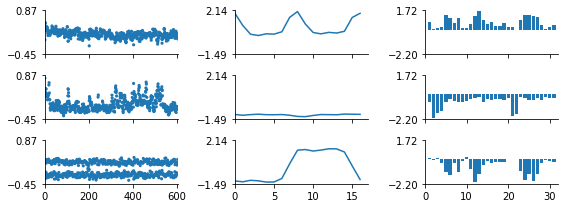

In [31]:
!pip install git+https://github.com/ahwillia/tensortools
import tensortools as tt
U = tt.cp_als(chunk['data'], rank=3, verbose=True)
fig, ax, po = tt.plot_factors(U.factors, plots=['scatter', 'line', 'bar'])

In this plot, each row is a different tensor component and each column is a different axis/dimension.
The output changes each time it is run.
Look for a component where the 1st column clearly shows two different groups of trials.
Then in the 2nd column we can see the time-course of that component, and in the 3rd column we see the channels that contributed to that component.

The next cell does the same thing with a slightly better plot, but is for Neuropype users only.
As it uses plotly, it won't show up in PyCharm (should be fixed in v2019.2) but it will in a browser.

In [32]:
import sys
sys.path.append(str(Path.cwd().parent / 'Intheon' / 'cpe'))
import neuropype.nodes as nn
pkt = nn.ImportH5(filename=str(test_file))()
tt_res = nn.TensorDecomposition(num_components=3, aggregate_axes=['instance'])(
    data=pkt, return_outputs='all')
type_map = {'time': 'lines', 'space': 'bars', 'instance': 'markers'}
plt = nn.TensorDecompositionPlot(output_mode='notebook', iv_field='Marker',
                                 type_map=type_map)(data=tt_res['model'])

ModuleNotFoundError: ignored

Let's try to classify these data using simple / shallow machine learning.
We'll use the excellent scikit-learn Python package.

https://scikit-learn.org/stable/modules/lda_qda.html

In [42]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import LeaveOneOut as LOO
from sklearn.model_selection import cross_val_score

X = chunk['data'].reshape((chunk['data'].shape[0], -1))
y = instance_axis['data']['Marker'].values
lda = LDA(shrinkage='auto', solver='eigen')
loo = LOO()

test_fold_predictions = []
for trn, tst in loo.split(X):
    lda.fit(X[trn], y[trn])
    test_fold_predictions.append(lda.predict(X[tst]))

y_preds = [_[0] for _ in test_fold_predictions]

[array(['face'], dtype='<U5'), array(['house'], dtype='<U5'), array(['ISI'], dtype='<U5'), array(['face'], dtype='<U5'), array(['ISI'], dtype='<U5'), array(['face'], dtype='<U5'), array(['ISI'], dtype='<U5'), array(['face'], dtype='<U5'), array(['ISI'], dtype='<U5'), array(['house'], dtype='<U5'), array(['ISI'], dtype='<U5'), array(['house'], dtype='<U5'), array(['ISI'], dtype='<U5'), array(['house'], dtype='<U5'), array(['ISI'], dtype='<U5'), array(['house'], dtype='<U5'), array(['ISI'], dtype='<U5'), array(['house'], dtype='<U5'), array(['ISI'], dtype='<U5'), array(['house'], dtype='<U5'), array(['ISI'], dtype='<U5'), array(['face'], dtype='<U5'), array(['ISI'], dtype='<U5'), array(['house'], dtype='<U5'), array(['ISI'], dtype='<U5'), array(['house'], dtype='<U5'), array(['ISI'], dtype='<U5'), array(['face'], dtype='<U5'), array(['ISI'], dtype='<U5'), array(['house'], dtype='<U5'), array(['ISI'], dtype='<U5'), array(['face'], dtype='<U5'), array(['ISI'], dtype='<U5'), array(['house']

[[<matplotlib.axis.YTick at 0x7f02139fbd68>,
 [Text(0, 0, 'ISI'), Text(0, 0, 'face'), Text(0, 0, 'house')],
 Text(0, 0.5, 'True label'),
 [Text(0, 0, 'ISI'), Text(0, 0, 'face'), Text(0, 0, 'house')],
 Text(0.5, 0, 'Predicted label')]

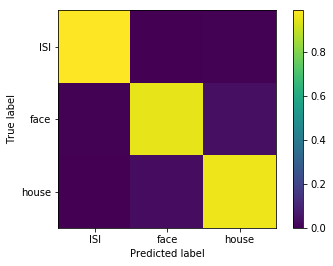

In [52]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt

classes = unique_labels(y, y_preds)
cm = confusion_matrix(y, y_preds)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
      yticks=np.arange(cm.shape[0]),
      # ... and label them with the respective list entries
      xticklabels=classes, yticklabels=classes,
      ylabel='True label',
      xlabel='Predicted label')